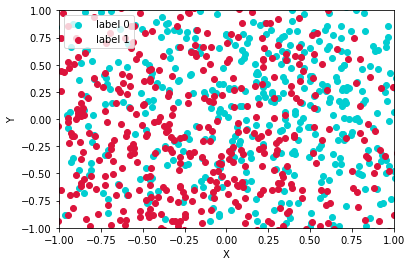

In [153]:
import scipy.stats as stats
import numpy as np 

from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt 

n_label0 = 1000
n_label1 = 1000
mean_0 = [0.5,0.5]
mean_1 = [-0.5,-0.5]
cov_0 = [1,1]
cov_1 = [1,1]
res0 = multivariate_normal.rvs(mean=mean_0,cov=cov_0,size=n_label0)
res1 = multivariate_normal.rvs(mean=mean_1,cov=cov_1,size=n_label1)

X0 = np.array(res0)
X1 = np.array(res1)
label0 = np.zeros(shape=(len(res0),1))
label1 = np.ones(shape=(len(res1),1))
colors1 = '#00CED1' 
colors2 = '#DC143C'

plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(xmax=1,xmin=-1)
plt.ylim(ymax=1,ymin=-1)
plt.scatter(X0[:,0],X0[:,1],c=colors1,label='label 0')
plt.scatter(X1[:,0],X1[:,1],c=colors2,label='label 1')
plt.legend()
plt.show()

## le classifieur Bayesien

Suppsons que la loi a pri

In [154]:

class Bayesien():
    def __init__(self,n_label0,n_label1,mean_0,mean_1):
        self.p_label_0 = n_label0/(n_label0 + n_label1)
        self.p_label_1 = n_label1/(n_label0 + n_label1)
        self.mean_0 = mean_0
        self.mean_1 = mean_1
        

    def predict(self,x):
        labels = np.ones(len(x))
        prob = (self.p_label_1 * np.exp(-0.5 * np.sum(np.square(x-self.mean_1),axis=1)))/(self.p_label_0 * np.exp(-0.5 * np.sum(np.square(x-self.mean_0),axis=1)) + self.p_label_1 *np.exp(-0.5 * np.sum(np.square(x-self.mean_1),axis=1)))
        for i in range(len(x)):
            labels[i] = 1 if prob[i] >= 0.5 else 0
        return labels

X_test = multivariate_normal.rvs(mean=mean_1,cov=cov_1,size=20)

bayes = Bayesien(n_label0,n_label1,mean_0,mean_1)
bayes.predict(X_test)

array([0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 1.])

## K-NN


In [155]:
class KNN():
    def __init__(self,label = 2):
        
        self.num_label = label

    def train(self,X,y):
        self.X_train = X
        self.y_train = y
        self.n ,self.dim= X.shape
        self.K = int(np.power(np.log(self.n),self.dim/(self.dim+2))*np.power(self.n,2/(self.dim+2)))

    def predict(self,X):
        labels = np.ones(len(X))
        for i in range(len(X)):
            labels[i] = self.get_label(X[i])

        return labels
    def get_label(self,x):
        x_neighbors = self.get_neighbor(x)
        neighbor_label = self.y_train[x_neighbors]
        neighbor_label = list(neighbor_label)
        res = neighbor_label[0]
        res_fre = neighbor_label.count(res)
        for label in neighbor_label:
            fre = neighbor_label.count(label)
            if(fre>res_fre):
                res = label
                res_fre = fre
            
        return res

        
    def get_neighbor(self,x):
        
        dis = list(map(lambda a: self.distance(a,x),self.X_train))
        pairs = sorted(zip(dis,np.arange(len(dis))),key = lambda x:x[0])[:self.K]
        neighbor_index = [p[1] for p in pairs]
        return neighbor_index
        
    
    def distance(self,x,a):
        return np.sqrt(np.sum(np.square(a-x)))






## LDA

In [156]:
class LDA():
    def __init__(self,dim_x=2):
        self.dim = dim_x

    def train(self,X,Y):
        nums = len(Y)
        nums_1 = np.sum(Y)
        nums_0 = nums - nums_1
        self.dim = len(X[0])
        
        self.p_prob_1 = np.sum(Y)/nums
        self.p_prob_0 = 1- self.p_prob_1
        self.mean_1 = np.reshape(np.sum(Y * X,axis=0)/nums_1,newshape=(1,self.dim))
        self.mean_0 = np.reshape(np.sum((1-Y)*X,axis=0)/nums_0,newshape=(1,self.dim))

        assert(self.mean_1.shape == (1,self.dim))
        self.cov = 0

        tmp0 = X - self.mean_0
        tmp1 = X - self.mean_1
        assert(tmp0.shape == (len(X),self.dim))
        
        for i in range(nums):
            self.cov += (1-Y[i]) * np.matmul(np.transpose(tmp0[i]).reshape(self.dim,1),tmp0[i].reshape(1,self.dim)) + Y[i] * np.matmul(np.transpose(tmp1[i]).reshape(self.dim,1),tmp1[i].reshape(1,self.dim))
        self.cov /= nums

        assert(self.cov.shape == (self.dim,self.dim))
        self.cov_inv = np.linalg.inv(self.cov)

    
        

    def predict(self,X):
        labels = np.ones(len(X))
        for i in range(len(X)):
            labels[i] = self.regressin(X[i])
        return labels
    
    def regressin(self,x):
        phi = np.matmul(np.matmul((self.mean_1 - self.mean_0),self.cov_inv),x.reshape(self.dim,1)) - 0.5 * np.matmul(np.matmul(self.mean_1,self.cov_inv),np.transpose(self.mean_1)) + 0.5*np.matmul(np.matmul(self.mean_0,self.cov_inv),np.transpose(self.mean_0)) + np.log(self.p_prob_1/self.p_prob_0)
        eta = 1/(1+np.exp(-phi))
        if eta[0] > 0.5:
            return 1
        else:
            return 0


## Test

In [161]:
p_label_0 = 0.5
n_label0 = int(10000 * p_label_0)
n_label1 = int(10000 * (1-p_label_0))
dim = 2
mean_0 = np.ones(2)*0.5
mean_1 = np.ones(2) * -0.5

cov_0 = [1,1]
cov_1 = [1,1]
res0 = multivariate_normal.rvs(mean=mean_0,cov=cov_0,size=n_label0)
res1 = multivariate_normal.rvs(mean=mean_1,cov=cov_1,size=n_label1)

X0 = np.array(res0)
X1 = np.array(res1)
label0 = np.zeros(shape=(len(res0),1))
label1 = np.ones(shape=(len(res1),1))

X_train = np.concatenate([X0,X1],0)
Y_train = np.concatenate([label0,label1],0)

bayes = Bayesien(n_label0,n_label1,mean_0,mean_1)
knn = KNN()
knn.train(X_train,Y_train)
lda = LDA()
lda.train(X_train,Y_train)

def error():
    test_samples = 20
    x0 = multivariate_normal.rvs(mean=mean_0,cov=cov_0,size=int(test_samples*p_label_0))
    x1 = multivariate_normal.rvs(mean=mean_1,cov=cov_1,size=int(test_samples*(1-p_label_0)))
    label0 = np.zeros(shape=(len(x0),1))
    label1 = np.ones(shape=(len(x1),1))

    X_test = np.concatenate([x0,x1],axis = 0)
    Y_test = np.concatenate([label0,label1],axis=0)

    prediction_bayes = bayes.predict(X_test)
    prediction_knn = knn.predict(X_test)
    prediction_lda = knn.predict(X_test)
    print(prediction_bayes)
    print(prediction_knn)
    print(prediction_lda)
    print(Y_test.reshape(-1))

error()





[1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0.]
[1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0.]
[1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
